In [696]:
import math
import random
import numpy
from functools import reduce
import sys
import getopt
import re
import time

In [697]:
optimalFile = 'E-n101-k14.sol'
testFile = 'E-n101-k14.vrp'

In [698]:
def parseVRPFile(fileName):
    f = open(fileName, "r", encoding="utf-8")
    content = f.read()
    #print("Content: ", content)
    optimalValue = re.search("Optimal value: (\d+)", content, re.MULTILINE)
    if(optimalValue != None):
        optimalValue = optimalValue.group(1)
    else:
        optimalValue = re.search("Best value: (\d+)", content, re.MULTILINE)
        if(optimalValue != None):
            optimalValue = optimalValue.group(1)
    capacity = re.search("^CAPACITY : (\d+)$", content, re.MULTILINE).group(1)
    #graph = re.findall(r"^ (\d+) (\d+) (\d+)$", content, re.MULTILINE)
    graph = re.findall(r"^(\d+) (\d+) (\d+)$", content, re.MULTILINE)
    dim = re.search("^DIMENSION : (\d+)$", content, re.MULTILINE).group(1)
    print("Graph: ", graph)
    dim = int(dim)
    print("dim: ", dim)
    #demand = re.findall(r"^(\d+) (\d+) $", content, re.MULTILINE)
    demand = re.findall(r"^(\d+) (\d+)$", content, re.MULTILINE)
    print("Demand: ", demand)
    graph = {int(a):(int(b),int(c)) for a,b,c in graph}
    print("graph: ", graph)
    demand = {int(a):int(b) for a,b in demand}
    print("demand: ", demand)
    capacity = int(capacity)
    optimalValue = int(optimalValue)
    return capacity, graph, demand, optimalValue, dim

In [699]:
#alpha and beta define what criteria is more important for us, pheromones or distance when an ant makes decision
alfa = 2 # importance of pheromones 
beta = 7 # importance of distance
ro = 0.1 # speed of pheromon evaporation
th = 80 # importance of avg current solutions' costs
iterations = 1000
ants = 14

In [700]:
def getGraph(Q, G, D, optimalValue):
    V = list(G.keys())
    V.remove(1)

    E = { (min(a,b),max(a,b)) : numpy.sqrt((G[a][0]-G[b][0])**2 + (G[a][1]-G[b][1])**2) for a in G.keys() for b in G.keys()}
    tau = { (min(a,b),max(a,b)) : 1 for a in G.keys() for b in G.keys() if a!=b } #pheromones
    
    return V, E, Q, D, tau, optimalValue

In [701]:
import math

In [702]:
def antSolution(V, E, Q, D, tau):
    solution = list()

    while(len(V)!=0): #начинаем со случайной
        path = list()
        city = numpy.random.choice(V)
        capacity = Q - D[city]
        path.append(city)
        V.remove(city)
        while(len(V)!=0):
            probabilities = list(map(lambda x: ((tau[(min(x,city), max(x,city))])**alfa)*((1/E[(min(x,city), max(x,city))])**beta), V)) #по формуле вычисляем вероятности пойти в каждую вершину
            #print(probabilities)
            for i in range(len(probabilities)):
              if math.isinf(probabilities[i]):
                probabilities[i] = 1.2224513299473679e-11
            probabilities = probabilities/numpy.sum(probabilities)
            
            city = numpy.random.choice(V, p=probabilities) #учитывая вероятности, берем рандомную, идем туда
            capacity = capacity - D[city]

            if(capacity > 0): #отдаем заказ, если можем, иначе заканчиваем маршрут
                path.append(city)
                V.remove(city)
            else:
                break
        solution.append(path)
    return solution


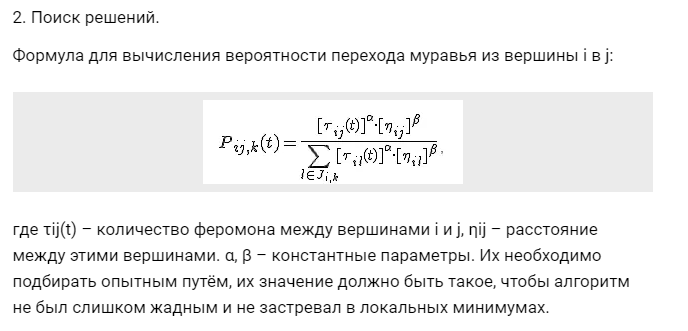

In [703]:
#вычисляем километраж пути
def getCommonDistance(solution, E):
    s = 0
    for i in solution:
        a = 1
        for j in i:
            b = j
            s = s + E[(min(a,b), max(a,b))]
            a = b
        b = 1
        s = s + E[(min(a,b), max(a,b))]
    return s

In [704]:
#нанесение феромона и поиск лучшего решения, исходя из километража
def updatePheromone(tau, solutions, bestSolution):
    Lavg = reduce(lambda x,y: x+y, (i[1] for i in solutions))/len(solutions) #формула для среднего значения цены решения для муравья
    tau = { k : (1 - ro) * v + th/Lavg for (k,v) in tau.items() } #формула для нанесения феромона
    solutions.sort(key = lambda x: x[1]) 
    if(bestSolution!=None):
        if(solutions[0][1] < bestSolution[1]):
            bestSolution = solutions[0]
    else:
        bestSolution = solutions[0]
    return bestSolution

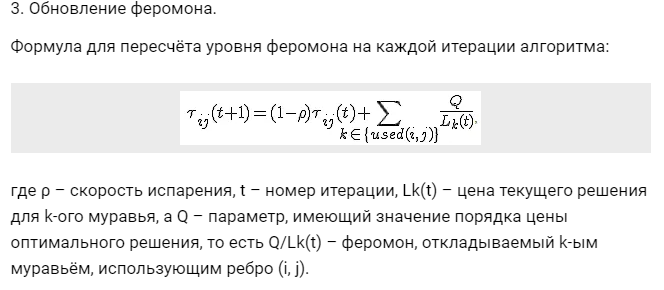

In [705]:
#G = (E,V) - graph
#E - edges
#V - vertices (nodes)
#Q - max capacity
#D - demands for all nodes
#tau - amount of pheromone

In [706]:
bestSolution = None
Q, G, D, optimalValue, dim = parseVRPFile(testFile)

Graph:  [('1', '35', '35'), ('2', '41', '49'), ('3', '35', '17'), ('4', '55', '45'), ('5', '55', '20'), ('6', '15', '30'), ('7', '25', '30'), ('8', '20', '50'), ('9', '10', '43'), ('10', '55', '60'), ('11', '30', '60'), ('12', '20', '65'), ('13', '50', '35'), ('14', '30', '25'), ('15', '15', '10'), ('16', '30', '5'), ('17', '10', '20'), ('18', '5', '30'), ('19', '20', '40'), ('20', '15', '60'), ('21', '45', '65'), ('22', '45', '20'), ('23', '45', '10'), ('24', '55', '5'), ('25', '65', '35'), ('26', '65', '20'), ('27', '45', '30'), ('28', '35', '40'), ('29', '41', '37'), ('30', '64', '42'), ('31', '40', '60'), ('32', '31', '52'), ('33', '35', '69'), ('34', '53', '52'), ('35', '65', '55'), ('36', '63', '65'), ('37', '2', '60'), ('38', '20', '20'), ('39', '5', '5'), ('40', '60', '12'), ('41', '40', '25'), ('42', '42', '7'), ('43', '24', '12'), ('44', '23', '3'), ('45', '11', '14'), ('46', '6', '38'), ('47', '2', '48'), ('48', '8', '56'), ('49', '13', '52'), ('50', '6', '68'), ('51', '47',

In [707]:
V, E, Q, D, tau, optimalValue = getGraph(Q, G, D, optimalValue)

In [708]:
start_time = time.time()
best = []
for i in range(iterations): #generations
  solutions = list()
  for _ in range(ants):
      solution = antSolution(V.copy(), E, Q, D, tau) #ant decides what path to take
      solutions.append((solution, getCommonDistance(solution, E))) #get solution and distance
  bestSolution = updatePheromone(tau, solutions, bestSolution) #update pheromone and get best
  best.append(bestSolution[1])
print("Solution: ", bestSolution) 
print("time of execution: %s seconds" %abs (time.time() - start_time)) # вычисление времени выполнения


Solution:  ([[47, 48, 49, 83, 8, 89], [74, 22, 73, 75, 76, 23, 42, 16, 58], [68, 40, 57, 24, 5], [59, 14, 95, 96, 98, 93, 38], [34, 82, 52, 10, 72, 36, 35, 79], [70, 2, 71, 31, 21, 67, 66, 4], [56, 26, 55, 69, 81, 13, 27], [54, 29, 77, 78, 80, 30, 25, 51], [86, 94, 60, 100, 97], [3, 88, 43, 44, 15, 45, 92, 17], [7, 90, 19, 84, 61, 6, 85, 18, 46, 9], [11, 33, 91, 64, 12, 20, 63], [37, 50, 65, 32, 53, 28, 41], [62, 87, 39, 101, 99]], 1282.6114227691835)
time of execution: 357.56325793266296 seconds


In [709]:
cost_from_alg = bestSolution[-1]
cost_from_alg

1282.6114227691835

In [710]:
def parseSOLFile(fileName):
  f = open(fileName, "r", encoding="utf-8")
  content = f.read()
  cost = re.search("^Cost (\d+)$", content, re.MULTILINE).group(1)
  return int(cost)

In [711]:
cost = parseSOLFile(optimalFile)
cost

1067

In [712]:
def compareResults(res1, res2):
  return abs(res1-res2)

In [713]:
compareResults(cost, cost_from_alg)

215.6114227691835

In [714]:
print("Time ", (abs (time.time() - start_time)))
print("Optimal ", cost)
print("In fact ", cost_from_alg)
print("Dim ", dim)
print("Diff ", cost_from_alg - cost)
print("Perc ", ((cost_from_alg - cost)/cost_from_alg)*100)

Time  357.63353180885315
Optimal  1067
In fact  1282.6114227691835
Dim  101
Diff  215.6114227691835
Perc  16.8103463715982
